In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
file_path = '/content/drive/MyDrive/Colab Notebooks/MachineLearningRating_v3.txt'

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
df = pd.read_csv(file_path, sep='|', encoding='utf-8', on_bad_lines='skip', low_memory=False)


In [35]:
# Filter policies with claims > 0 for the severity model
claims_data = df[df['TotalClaims'] > 0].copy()

# Drop high-missing or irrelevant columns (if any)
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# Fill missing numeric with median and categorical with mode
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-35-3601913332>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-35-3601913332>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-35-3601913332>:13: FutureWarning: A value is trying to be set on a copy of a

In [36]:
# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [37]:
datetime_cols = ['PolicyStartDate', 'ClaimDate', 'PolicyEndDate']  # replace with actual column names from your data

# Convert datetime columns to pandas datetime
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

        # Feature engineering: extract year, month, day
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day

        # Optionally: days since a reference date
        df[f'{col}_since'] = (df[col] - pd.to_datetime('2000-01-01')).dt.days

        # Drop original datetime column
        df.drop(columns=[col], inplace=True)

In [38]:
# Show any non-numeric columns remaining
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['IsVATRegistered', 'TransactionMonth_2013-11-01 00:00:00',
       'TransactionMonth_2013-12-01 00:00:00',
       'TransactionMonth_2014-01-01 00:00:00',
       'TransactionMonth_2014-02-01 00:00:00',
       'TransactionMonth_2014-03-01 00:00:00',
       'TransactionMonth_2014-04-01 00:00:00',
       'TransactionMonth_2014-05-01 00:00:00',
       'TransactionMonth_2014-06-01 00:00:00',
       'TransactionMonth_2014-07-01 00:00:00',
       ...
       'CoverGroup_Standalone passenger liability',
       'CoverGroup_Third Party Only', 'CoverGroup_Trailer',
       'Section_Motor Comprehensive', 'Section_Optional Extended Covers',
       'Section_Standalone passenger liability',
       'Section_Third party or third party, fire and theft only',
       'Product_Mobility Commercial Cover: Monthly',
       'Product_Mobility Metered Taxis: Monthly',
       'Product_Standalone Passenger Liability'],
      dtype='object', length=1504)


In [39]:
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

In [41]:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in X_train:", non_numeric_cols)

Non-numeric columns in X_train: Index(['TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType',
       'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender',
       'Country', 'Province', 'MainCrestaZone', 'SubCrestaZone', 'ItemType',
       'VehicleType', 'make', 'Model', 'bodytype', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
       'CoverGroup', 'Section', 'Product', 'StatutoryClass',
       'StatutoryRiskType'],
      dtype='object')


In [42]:
# Optionally: encode if they're categories
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align test set with train set columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Only use rows where claims are present
df_claims = df[df['TotalClaims'] > 0].copy()

# Convert date columns to datetime
date_cols = ['PolicyStartDate', 'PolicyEndDate', 'ClaimDate']  # update with your actual date columns
for col in date_cols:
    if col in df_claims.columns:
        df_claims[col] = pd.to_datetime(df_claims[col], errors='coerce')

# Extract useful features from dates
for col in date_cols:
    if col in df_claims.columns:
        df_claims[col + '_year'] = df_claims[col].dt.year
        df_claims[col + '_month'] = df_claims[col].dt.month

# Drop original date columns
df_claims.drop(columns=[col for col in date_cols if col in df_claims.columns], inplace=True)


# Select numeric and categorical columns
categorical_cols = df_claims.select_dtypes(include='object').columns
df_claims = pd.get_dummies(df_claims, columns=categorical_cols, drop_first=True)
X = df_claims.drop(columns=['TotalClaims'])
y = df_claims['TotalClaims']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)
# Predict
y_pred = model.predict(X_test)


In [47]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

Linear Regression RMSE: 38879.70
R-squared: 0.0601


In [48]:
!pip install shap

In [49]:
import shap
# SHAP expects a model with coef_ attribute and a NumPy array input
explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

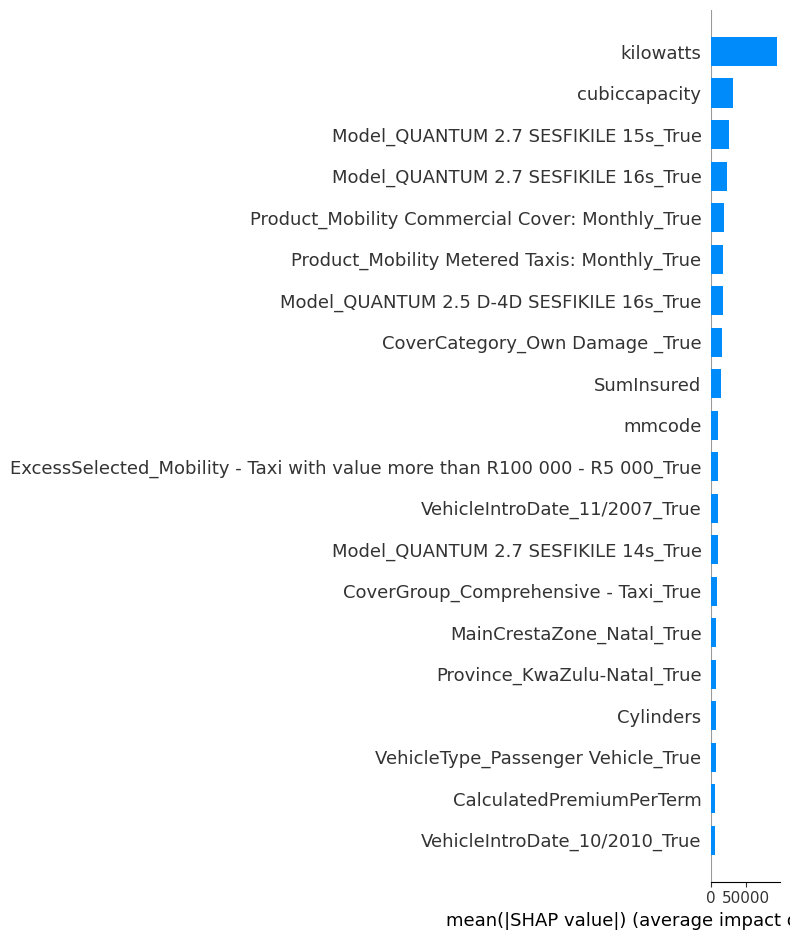

In [50]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [52]:
import numpy as np
# Convert to numpy arrays if needed
X_train_np = X_train.values
X_test_np = X_test.values

# Use the LinearExplainer
explainer = shap.LinearExplainer(model, X_train_np, feature_perturbation="interventional")
shap_values = explainer(X_test_np)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


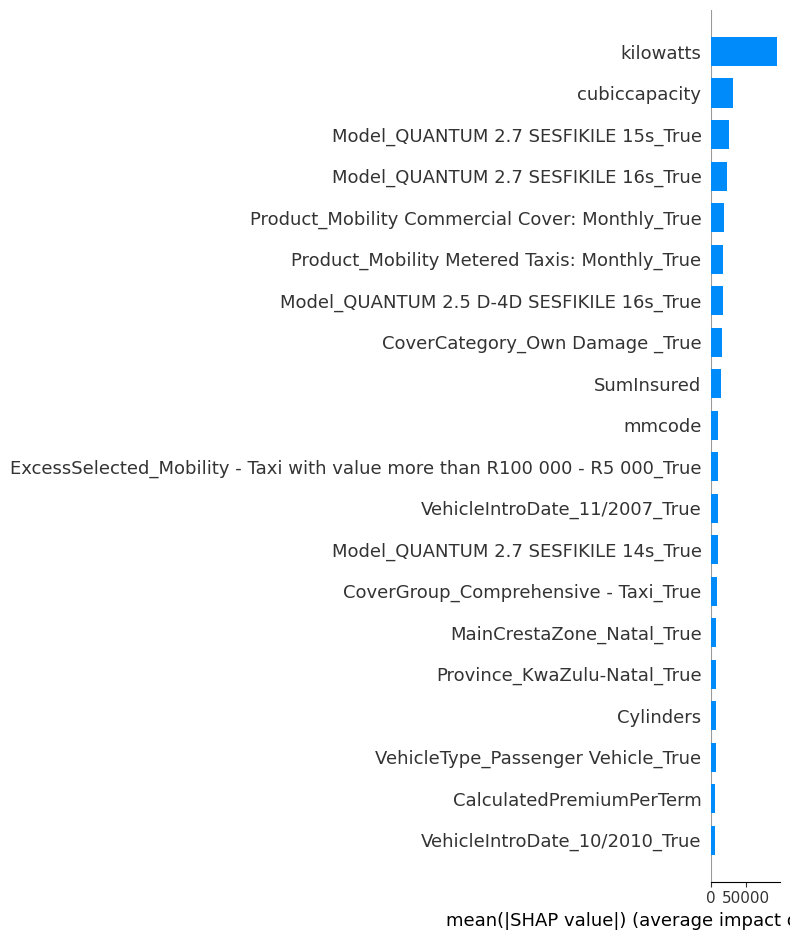